In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Solo muestra errores cr√≠ticos (no warnings)
import requests
from tqdm import tqdm 
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, precision_recall_curve
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TerminateOnNaN
import uuid
import gc
import shutil

In [4]:
#Cargamos los datos y los unificamos en un dataframe
datos1 = pd.read_csv('data/datos1.csv')
datos2 = pd.read_csv('data/datos2.csv')
datos3 = pd.read_csv('data/datos3.csv')
datos4 = pd.read_csv('data/datos4.csv')
datos5 = pd.read_csv('data/datos5.csv')

total_datos= pd.concat([datos1,datos2,datos3,datos4,datos5])

df= pd.DataFrame(total_datos)

In [5]:
# Visualiazmos las primeras filas
pd.set_option('display.max_columns', None)
df.head()

Spotting ID    Bee Spotter Date Spotted Date Submitted               Title  \
0         1092       Gretchen    6/20/2003      1/24/2009       Bee in DeKalb   
1          132         bmovie     9/2/2004     11/22/2007   Tomato Garden Bee   
2          327  aurthur2sheds    7/12/2005      6/26/2008      map_test_trial   
3          403      HaarFager    4/19/2006       7/7/2008  Bombus Impatiens 1   
4          213    CityEcology     5/4/2006       5/2/2008         BB 20060504   

                 Latitude             Longitude  \
0             419.183.499          -887.589.572   
1   3.854.725.920.476.960  -900.179.386.138.916   
2  40.332.715.559.869.400  -887.679.648.399.353   
3   3.798.067.170.307.880  -883.326.530.456.543   
4     393.072.064.165.576  -765.523.910.522.461   

  Amateur Species Identification Expert Species Identification (Primary)  \
0                            NaN                          Apis mellifera   
1                            NaN                        Bombus impatiens   
2                            NaN                     Bombus griseocollis   
3                            NaN                     Bombus griseocollis   
4               Bombus impatiens                        Bombus impatiens   

  Expert Species Identification (Secondary) Protected Species?  \
0                                       NaN                  f   
1                                       NaN                  f   
2                                       NaN                  f   
3                                       NaN                  f   
4                                       NaN                  f   

  Location Obscured?     Sex   Caste                     Spotting URL  \
0                  f     NaN     NaN  https://beespotter.org/bee/1092   
1                  f  female  Worker   https://beespotter.org/bee/132   
2                  f  female  Worker   https://beespotter.org/bee/327   
3                  f  female   Queen   https://beespotter.org/bee/403   
4                  f  female   Queen   https://beespotter.org/bee/213   

   Number of Days Between Date Spotted and Date Added to Site  Photo ID  \
0                                               2045               1863   
1                                               1176                271   
2                                               1080                579   
3                                                810                721   
4                                                729                384   

   Rating Has Pollen on Legs Flower  \
0     8.0                 No    NaN   
1     8.0                 No    NaN   
2    10.0                Yes    NaN   
3    10.0                 No    NaN   
4     NaN                 No    NaN   

                                        Image URL  
0  https://beespotter.org/beedata/bees/1092-1.jpg  
1   https://beespotter.org/beedata/bees/132-1.jpg  
2   https://beespotter.org/beedata/bees/327-1.jpg  
3   https://beespotter.org/beedata/bees/403-1.jpg  
4   https://beespotter.org/beedata/bees/213-1.jpg

In [6]:
# Comprobamos el tama√±o
df.shape

(24731, 21)

In [7]:
# Comprobamos tipos de variables
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24731 entries, 0 to 3233
Data columns (total 21 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Spotting ID                                                 24731 non-null  int64  
 1   Bee Spotter                                                 24731 non-null  object 
 2   Date Spotted                                                24731 non-null  object 
 3   Date Submitted                                              24731 non-null  object 
 4   Title                                                       24729 non-null  object 
 5   Latitude                                                    24490 non-null  object 
 6   Longitude                                                   24490 non-null  object 
 7   Amateur Species Identification                              20509 non-null  object 
 8   Ex

In [8]:
# Comprobaci√≥n duplicados
df.duplicated().sum()

0

In [9]:
# Comprobaci√≥n nulos
df.isnull().sum()

Spotting ID                                                       0
Bee Spotter                                                       0
Date Spotted                                                      0
Date Submitted                                                    0
Title                                                             2
Latitude                                                        241
Longitude                                                       241
Amateur Species Identification                                 4222
Expert Species Identification (Primary)                           0
Expert Species Identification (Secondary)                     24719
Protected Species?                                                0
Location Obscured?                                                0
Sex                                                             933
Caste                                                           952
Spotting URL                                    

In [10]:
# Comprobamos valores √∫nicos
df.nunique()

Spotting ID                                                   11201
Bee Spotter                                                    1246
Date Spotted                                                   2290
Date Submitted                                                 2128
Title                                                          9499
Latitude                                                       8503
Longitude                                                      8230
Amateur Species Identification                                   14
Expert Species Identification (Primary)                          13
Expert Species Identification (Secondary)                         4
Protected Species?                                                2
Location Obscured?                                                2
Sex                                                               3
Caste                                                             3
Spotting URL                                    

In [11]:
# Convertimos la columna a min√∫sculas para evitar problemas 
df["Expert Species Identification (Primary)"] = df["Expert Species Identification (Primary)"].str.lower()

# Comprobamos el n√∫mero de observaciones que tenemos de abejas apis y bombus
count_apis =0
count_bombus =0
for i in df["Expert Species Identification (Primary)"]:
    if "apis" in i:
        count_apis +=1
    elif "bombus" in i:
        count_bombus +=1

print("cantidad de apis:", count_apis)
print("Cantidad de bombus:", count_bombus)

cantidad de apis: 3758
Cantidad de bombus: 20973


In [12]:
df["Expert Species Identification (Primary)"].value_counts()

Expert Species Identification (Primary)
bombus impatiens        5467
bombus griseocollis     4777
apis mellifera          3758
bombus bimaculatus      3251
bombus auricomus        1957
bombus pensylvanicus    1471
bombus fervidus         1217
bombus affinis           977
bombus rufocinctus       730
bombus citrinus          689
bombus vagans            312
bombus fraternus         117
bombus perplexus           8
Name: count, dtype: int64

El conteo de los tipos de abeja de los que disponemos en nuestro dataset nos indica que los datos que tenemos est√°n claramente desbalanceados.

Para balancear los datos, vamos a seleccionar un n√∫mero aleatorio de imagenes de abeja bombus, y aplicar augmentation en las imagenes de abejas apis. Con esto conseguiremos un dataset balanceado a un 60-40% aproximadamente.

In [ ]:
# Creamos 2 dataframes, uno para bombus y otro para apis
df_apis = df[df["Expert Species Identification (Primary)"].str.contains('apis')]
df_bombus = df[df["Expert Species Identification (Primary)"].str.contains ('bombus')]

# Definimos las carpetas de destino para cada tipolog√≠a

directorio_apis = ('data/images_apis')
directorio_bombus = ('data/images_bombus')

imagenes = 'Image URL'

# Definimos la funci√≥n para descargar imagenes
def descargar_imagenes(df, carpeta, especie):
    for i, row in df.iterrows():
        img_url = row[imagenes]
        img_name = os.path.join(carpeta, f"{especie}_{i}.jpg")  

        try:
            response = requests.get(img_url, stream=True, verify=False)
            if response.status_code == 200:
                with open(img_name, "wb") as file:
                    for chunk in response.iter_content(1024):
                        file.write(chunk)
                print(f"Descargada: {img_name}")
            else:
                print(f"Error al descargar {img_url} (Status code: {response.status_code})")
        except Exception as e:
            print(f"Error con {img_url}: {e}")

# Descargamos las imagenes de apis en la carpeta de apis
descargar_imagenes(df_apis, directorio_apis, "apis")
print("Descarga de im√°genes de apis completada.")

# Descargamos las imagenes de bombus en la carpeta de bombus
descargar_imagenes(df_bombus, directorio_bombus, "bombus")
print("Descarga de im√°genes de bombus completada.")

Descarga de im√°genes de apis completada.
Descarga de im√°genes de bombus completada.


In [14]:
# Definimos las rutas de las carpetas donde est√°n las im√°genes ya descargadas
directorio_base = "/home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/"
carpetas = ["apis", "bombus"]

# Listas para almacenar los datos
especies = []
rutas_imagenes = []

# Recorremos cada carpeta y obtenemos las im√°genes
for carpeta in carpetas:
    ruta_carpeta = os.path.join(directorio_base, carpeta)
    
    # Verificar si la carpeta existe, filtramos las im√°genes y definimos la especie con el nombre de la carpeta
    if os.path.exists(ruta_carpeta):
        for archivo in os.listdir(ruta_carpeta):
            if archivo.endswith((".jpg", ".png", ".jpeg")):  
                rutas_imagenes.append(os.path.join(ruta_carpeta, archivo))
                especies.append(carpeta) 

# Creamos un nuevo dataframe con las url de las im√°genes descargadas y la especie
df_imagenes = pd.DataFrame({"especie": especies, "imagen_descargada": rutas_imagenes})

# Mapeamos las etiquetas: 'apis' -> 0, 'bombus' -> 1
df_imagenes["especie"] = df_imagenes["especie"].map({"apis": 0, "bombus": 1})

#Verificamos el tama√±o de nuestro conjunto de datos filtrado
df_imagenes.shape

(12374, 2)

In [15]:
# Ajustamos la visualizaci√≥n de pandas para mostrar texto largo en las columnas
pd.set_option('display.max_colwidth', None)
df_imagenes.head()

especie  \
0        0   
1        0   
2        0   
3        0   
4        0   

                                                                        imagen_descargada  
0  /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/apis/1250_apis.jpg  
1  /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/apis/3108_apis.jpg  
2  /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/apis/1681_apis.jpg  
3  /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/apis/2756_apis.jpg  
4   /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/apis/558_apis.jpg

In [16]:
from PIL import Image

# Funci√≥n para verificar si una imagen es v√°lida
def es_imagen_valida(ruta):
    try:
        with Image.open(ruta) as img:
            img.verify()  # Verifica si la imagen est√° da√±ada
        return True
    except Exception:
        return False

# Verificar im√°genes corruptas
print(" Verificando im√°genes corruptas...")

df_imagenes["valida"] = df_imagenes["imagen_descargada"].apply(es_imagen_valida)

# Contar im√°genes corruptas
num_imagenes_corruptas = df_imagenes["valida"].value_counts().get(False, 0)

# Mostrar n√∫mero de im√°genes corruptas
print(f" N√∫mero de im√°genes que no se pueden abrir: {num_imagenes_corruptas}")

# Obtener la lista de im√°genes corruptas
imagenes_corruptas = df_imagenes[df_imagenes["valida"] == False]["imagen_descargada"].tolist()

# Mostrar la lista de im√°genes corruptas si hay menos de 20
if num_imagenes_corruptas > 0:
    print("\n Lista de im√°genes corruptas:")
    for img in imagenes_corruptas[:20]:  # Muestra hasta 20 im√°genes corruptas
        print(img)
    if num_imagenes_corruptas > 20:
        print(f"... (Se han detectado m√°s im√°genes corruptas, pero solo se muestran 20)")


 Verificando im√°genes corruptas...
 N√∫mero de im√°genes que no se pueden abrir: 0


In [17]:
#ELIMINAR IM√ÅGENES CORRUPTAS DEL DISCO
if num_imagenes_corruptas > 0:
    print("\nüóë Eliminando im√°genes corruptas...")
    for img_path in imagenes_corruptas:
        try:
            if os.path.exists(img_path):
                os.remove(img_path)  # Eliminar archivo
                print(f" Imagen eliminada: {img_path}")
            else:
                print(f" Imagen no encontrada (ya eliminada o movida): {img_path}")
        except Exception as e:
            print(f" Error al eliminar {img_path}: {e}")

    print("\n Todas las im√°genes corruptas han sido eliminadas.")

# Filtrar solo im√°genes v√°lidas en el DataFrame
df_imagenes = df_imagenes[df_imagenes["valida"] == True].drop(columns=["valida"]).reset_index(drop=True)

# Confirmar el n√∫mero de im√°genes v√°lidas despu√©s de la limpieza
print(f"\n Im√°genes v√°lidas restantes en el dataset: {len(df_imagenes)}")


 Im√°genes v√°lidas restantes en el dataset: 12374


In [18]:
# Definir X (entrada) e Y (salida)
X = df_imagenes["imagen_descargada"]  
Y = df_imagenes["especie"] 

# Dividir en train (60%), val (20%) y test (20%)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, stratify=Y, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=42)

# Crear DataFrames finales
train_df = pd.DataFrame({"imagen_descargada": X_train, "especie": Y_train})
val_df = pd.DataFrame({"imagen_descargada": X_val, "especie": Y_val})
test_df = pd.DataFrame({"imagen_descargada": X_test, "especie": Y_test})

# Convertir las etiquetas a int32 (por seguridad)
train_df["especie"] = train_df["especie"].astype("int32")
val_df["especie"] = val_df["especie"].astype("int32")
test_df["especie"] = test_df["especie"].astype("int32")

# Confirmar tama√±o de los sets
print("Tama√±o del set de entrenamiento:", train_df.shape)
print("Tama√±o del set de validaci√≥n:", val_df.shape)
print("Tama√±o del set de prueba:", test_df.shape)


Tama√±o del set de entrenamiento: (7424, 2)
Tama√±o del set de validaci√≥n: (2475, 2)
Tama√±o del set de prueba: (2475, 2)


In [19]:
# Verificar la distribuci√≥n de clases en cada conjunto
print("Distribuci√≥n de clases en el dataset de entrenamiento:")
print(train_df["especie"].value_counts(normalize=True))

print("\nDistribuci√≥n de clases en el dataset de validaci√≥n:")
print(val_df["especie"].value_counts(normalize=True))

print("\nDistribuci√≥n de clases en el dataset de prueba:")
print(test_df["especie"].value_counts(normalize=True))

# Verificar si hay im√°genes duplicadas entre train, val y test
train_paths = set(train_df["imagen_descargada"])
val_paths = set(val_df["imagen_descargada"])
test_paths = set(test_df["imagen_descargada"])

print("\n¬øTrain y Val tienen im√°genes en com√∫n?", not train_paths.isdisjoint(val_paths))
print("¬øTrain y Test tienen im√°genes en com√∫n?", not train_paths.isdisjoint(test_paths))
print("¬øVal y Test tienen im√°genes en com√∫n?", not val_paths.isdisjoint(test_paths))


Distribuci√≥n de clases en el dataset de entrenamiento:
especie
1    0.753637
0    0.246363
Name: proportion, dtype: float64

Distribuci√≥n de clases en el dataset de validaci√≥n:
especie
1    0.753535
0    0.246465
Name: proportion, dtype: float64

Distribuci√≥n de clases en el dataset de prueba:
especie
1    0.753535
0    0.246465
Name: proportion, dtype: float64

¬øTrain y Val tienen im√°genes en com√∫n? False
¬øTrain y Test tienen im√°genes en com√∫n? False
¬øVal y Test tienen im√°genes en com√∫n? False


In [20]:
print(train_df["especie"].dtype)
print(train_df.dtypes)
print(val_df.dtypes)
print(test_df.dtypes)

int32
imagen_descargada    object
especie               int32
dtype: object
imagen_descargada    object
especie               int32
dtype: object
imagen_descargada    object
especie               int32
dtype: object


In [ ]:
#  Par√°metros del modelo

IMG_SIZE = (224, 224) 
BATCH_SIZE = 16
EPOCHS = 100 
LEARNING_RATE = 0.0001

def load_img_from_path(img_path, label):
    img_path = img_path.numpy().decode("utf-8")

    try:
        image = load_img(img_path, target_size=IMG_SIZE)
        image = img_to_array(image)
        image = preprocess_input(image)
    except Exception as e:
        print(f"Error al cargar imagen {img_path}: {e}")
        # Reemplazo con imagen gris neutra 
        image = tf.ones((224, 224, 3), dtype=tf.float32) * 127.0
        image = preprocess_input(image)  # igualamos el formato 

    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.ensure_shape(image, (224, 224, 3))
    label = tf.cast(label, tf.float32)
    label = tf.ensure_shape(label, ())
    return image, label



# Funci√≥n para procesar datasets (entrenamiento, validaci√≥n y prueba)
def process_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((
        tf.convert_to_tensor(df["imagen_descargada"].values, dtype=tf.string),  
        tf.convert_to_tensor(df["especie"].values, dtype=tf.int32)
            ))

    # Aplicar la funci√≥n de carga de im√°genes usando tf.py_function
    dataset = dataset.map(
        lambda x, y: tf.py_function(func=load_img_from_path, inp=[x, y], Tout=[tf.float32, tf.float32]),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Asegurar que la forma de los datos sea correcta
    dataset = dataset.map(lambda x, y: (tf.ensure_shape(x, (224, 224, 3)), tf.ensure_shape(y, ())))

    # Agrupar en lotes y optimizar la carga
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    return dataset


# Crear los datasets de entrenamiento, validaci√≥n y prueba
train_dataset = process_dataset(train_df)
val_dataset = process_dataset(val_df)
test_dataset = process_dataset(test_df)

I0000 00:00:1742842965.644937    5673 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742842965.730349    5673 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742842965.734140    5673 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742842965.741014    5673 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [22]:
# Comprobar que el formato de las im√°genes es correcto en los dataset train, val y test
for image_batch, label_batch in train_dataset.take(1):
    print("Forma de batch de im√°genes (train):", image_batch.shape)
    print("Forma de batch de etiquetas (train):", label_batch.shape)

for image_batch, label_batch in val_dataset.take(1):
    print("Forma de batch de im√°genes (val):", image_batch.shape)
    print("Forma de batch de etiquetas (val):", label_batch.shape)

for image_batch, label_batch in test_dataset.take(1):
    print("Forma de batch de im√°genes (test):", image_batch.shape)
    print("Forma de batch de etiquetas (test):", label_batch.shape)

Forma de batch de im√°genes (train): (16, 224, 224, 3)
Forma de batch de etiquetas (train): (16,)
Forma de batch de im√°genes (val): (16, 224, 224, 3)
Forma de batch de etiquetas (val): (16,)
Forma de batch de im√°genes (test): (16, 224, 224, 3)
Forma de batch de etiquetas (test): (16,)


In [ ]:
def export_images_from_dataframe(df, output_dir="dataset_final/train"):
    os.makedirs(output_dir, exist_ok=True)

    if df.empty:
        print("El DataFrame est√° vac√≠o. No hay im√°genes que exportar.")
        return

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Copiando im√°genes"):
        img_path = row["imagen_descargada"]
        label = str(row["especie"])  # '0' o '1'

        # Verifica que el archivo existe
        if not os.path.exists(img_path):
            print(f"Imagen no encontrada: {img_path}")
            continue

        # Crear carpeta por clase
        class_dir = os.path.join(output_dir, label)
        os.makedirs(class_dir, exist_ok=True)

        img_filename = os.path.basename(img_path)
        dest_path = os.path.join(class_dir, img_filename)

        try:
            shutil.copy(img_path, dest_path)
            #print(f"Copiada: {img_path} ‚Üí {dest_path}")  
        except Exception as e:
            print(f"Error copiando {img_path}: {e}")

    print(f"\nIm√°genes exportadas en: {output_dir}")


export_images_from_dataframe(train_df, output_dir="dataset_final/train")


## ¬øPor qu√© hacer Data Augmentation desde carpetas y no desde el DataFrame?

Durante el desarrollo del proyecto de clasificaci√≥n de abejas (*Apis* vs *Bombus*), inicialmente se intent√≥ realizar el data augmentation directamente desde un DataFrame que conten√≠a las im√°genes cargadas en memoria (como arrays). Sin embargo, este enfoque gener√≥ varios problemas importantes, especialmente relacionados con el uso de memoria y estabilidad del proceso.

### Problemas detectados con el DataFrame
- El DataFrame combinaba im√°genes originales y aumentadas como arrays `numpy`, lo que implicaba mantener miles de im√°genes cargadas en RAM.
- A medida que el n√∫mero de im√°genes aumentaba (especialmente despu√©s del augmentation), el consumo de memoria se disparaba.
- El sistema empez√≥ a cerrar procesos de forma inesperada o lanzar errores por falta de memoria (`Killed` o errores de memoria de TensorFlow).
- Adem√°s, trabajar con arrays directamente en el DataFrame limitaba la reutilizaci√≥n de estas im√°genes para entrenamientos posteriores.


### Soluci√≥n adoptada: trabajar desde carpetas
Para solucionar estos problemas, se opt√≥ por una estrategia mucho m√°s robusta y escalable:

1. Descargar todas las im√°genes y guardarlas en carpetas organizadas por clase (`apis` y `bombus`).
2. Guardar la partici√≥n de entrenamiento en una carpeta separada (`dataset_final/train`) dividida por clases.
3. Realizar el Data Augmentation a partir de esas carpetas, usando `ImageDataGenerator` y guardando las nuevas im√°genes generadas en subcarpetas (`augmented/augmented_apis`, `augmented/augmented_bombus`).

---

### Ventajas de trabajar desde carpetas

#### 1. **Eficiencia en memoria**
- No es necesario mantener miles de im√°genes en RAM.
- Las im√°genes se cargan y procesan en tiempo real, una a una, durante el entrenamiento.
- Esto evita cuelgues o cierres del proceso por problemas de memoria.

#### 2. **Escalabilidad**
- Se pueden generar decenas de miles de im√°genes sin preocuparse por el tama√±o del DataFrame.
- Es m√°s f√°cil reutilizar las im√°genes ya augmentadas para distintos experimentos.

#### 3. **Claridad y organizaci√≥n**
- Tener las im√°genes organizadas en carpetas por clase facilita mucho su revisi√≥n y gesti√≥n.
- Es un enfoque compatible con herramientas est√°ndar de deep learning como `flow_from_directory`.

#### 4. **Producci√≥n e integraci√≥n**
- En un entorno real o de producci√≥n, es mucho m√°s pr√°ctico trabajar con carpetas.
- Los sistemas de entrenamiento en servidores o plataformas como TensorFlow Serving o TFLite esperan im√°genes en disco, no en memoria.
- Facilita la automatizaci√≥n y la integraci√≥n con pipelines MLOps o servidores de inferencia.

---

### Observaciones Finales

Aunque trabajar con im√°genes directamente en el DataFrame puede parecer c√≥modo para experimentos r√°pidos, en un proyecto como este lo m√°s adecuado que hemos encontrado es:

- Descargar las im√°genes a disco.
- Organizar las particiones (`train`, `val`, `test`) en carpetas separadas.
- Realizar el data augmentation desde las carpetas, guardando los resultados en carpetas espec√≠ficas por clase.

Este enfoque no solo evita errores de memoria, sino que adem√°s permite una transici√≥n m√°s limpia hacia producci√≥n, facilita nuevas iteraciones y asegura que el modelo pueda ser reentrenado o ajustado en el futuro sin depender de la memoria del sistema.



In [24]:
#Early Stopping
early_stopper = EarlyStopping(
    monitor="val_loss",  
    patience=5,          
    restore_best_weights=True,  
    verbose=1
)
# Obtener los nombres de las clases
class_names = train_df["especie"].unique()

# Crear un diccionario de pesos de clases
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array(class_names),
    y=train_df["especie"]
)
class_weight_dict = {class_name: weight for class_name, weight in zip(class_names, class_weights)}

print(f"Pesos asignados a cada clase: {class_weight_dict}")
# Cargamos modelo EfficientNetB0 sin la capa superior
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Congelamos las capas base

# Agregamos capas personalizadas para clasificaci√≥n binaria
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

# Definimos el modelo final
model = Model(inputs=base_model.input, outputs=output)

# Compilamos el modelo
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
              loss="binary_crossentropy", metrics=["accuracy",  Precision(name="precision"), 
            Recall(name="recall"), AUC(name="AUC")])

Pesos asignados a cada clase: {1: 0.663449508489723, 0: 2.029524330235101}


In [25]:
# Desactivar logs de XLA y CUDA
tf.get_logger().setLevel('ERROR')

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS, 
    class_weight=class_weight_dict, 
    callbacks=[early_stopper],  
    verbose=1
)
model.save("modelo_abejas.keras")

Epoch 1/100


I0000 00:00:1742842972.357446   31965 service.cc:146] XLA service 0x70553c14f440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742842972.357468   31965 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9


 10/464 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 18ms/step - AUC: 0.6661 - accuracy: 0.7026 - loss: 0.6037 - precision: 0.8701 - recall: 0.7430

I0000 00:00:1742842984.549274   31965 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


215/464 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 31s 128ms/step - AUC: 0.7244 - accuracy: 0.7174 - loss: 0.6007 - precision: 0.8562 - recall: 0.7587Error al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/bombus/2273_bombus.jpg: image file is truncated (0 bytes not processed)
368/464 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 128ms/step - AUC: 0.7732 - accuracy: 0.7378 - loss: 0.5616 - precision: 0.8764 - recall: 0.7638Error al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/apis/589_apis.jpg: image file is truncated (18 bytes not processed)
463/464 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 126ms/step - AUC: 0.7921 - accuracy: 0.7471 - loss: 0.5429 - precision: 0.8851 - recall: 0.7675Error al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/apis/1270_apis.jpg: image file is truncated (10 bytes not processed)
Error al cargar

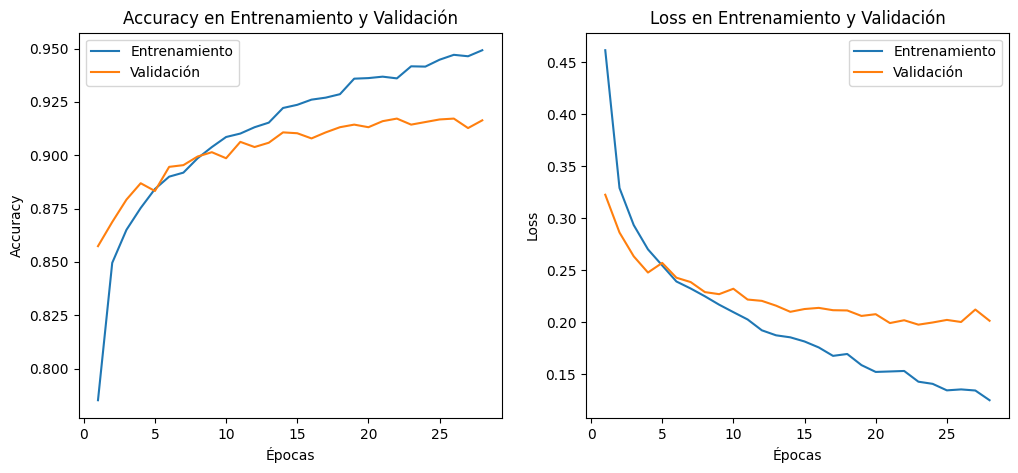

In [26]:
#Accurancy y Loss - Train y Val
# Extraer m√©tricas del historial de entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Graficar Accuracy y Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validaci√≥n')
plt.xlabel('√âpocas')
plt.ylabel('Accuracy')
plt.title('Accuracy en Entrenamiento y Validaci√≥n')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validaci√≥n')
plt.xlabel('√âpocas')
plt.ylabel('Loss')
plt.title('Loss en Entrenamiento y Validaci√≥n')
plt.legend()

plt.show()

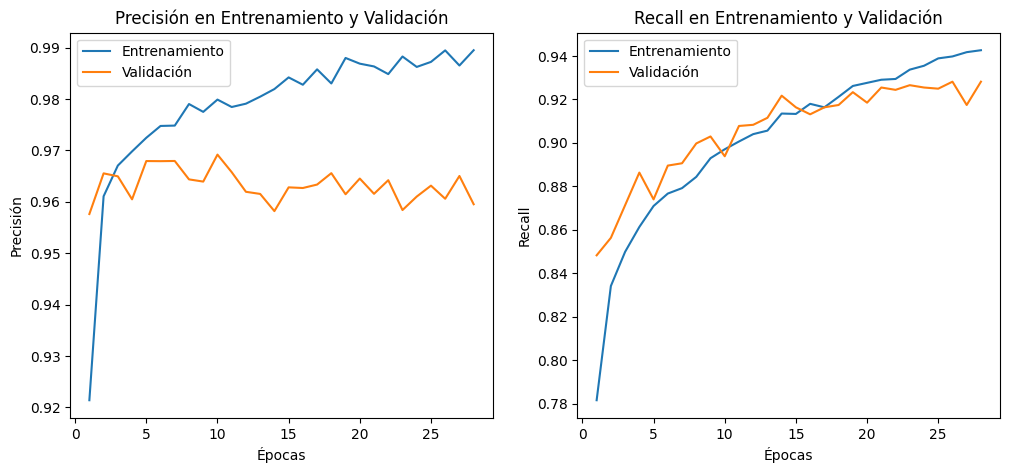

In [27]:
#Precision y Recall - Train y Val
# Extraer m√©tricas del historial de entrenamiento
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

#  Graficar Precisi√≥n y Recall
plt.figure(figsize=(12, 5))

# Precision
plt.subplot(1, 2, 1)
plt.plot(epochs_range, precision, label='Entrenamiento')
plt.plot(epochs_range, val_precision, label='Validaci√≥n')
plt.xlabel('√âpocas')
plt.ylabel('Precisi√≥n')
plt.title('Precisi√≥n en Entrenamiento y Validaci√≥n')
plt.legend()

# Recall
plt.subplot(1, 2, 2)
plt.plot(epochs_range, recall, label='Entrenamiento')
plt.plot(epochs_range, val_recall, label='Validaci√≥n')
plt.xlabel('√âpocas')
plt.ylabel('Recall')
plt.title('Recall en Entrenamiento y Validaci√≥n')
plt.legend()

plt.show()


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 3s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 68ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 61ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 65ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 45ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 49ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 59ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 71ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 61ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 46ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 50ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 43ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0

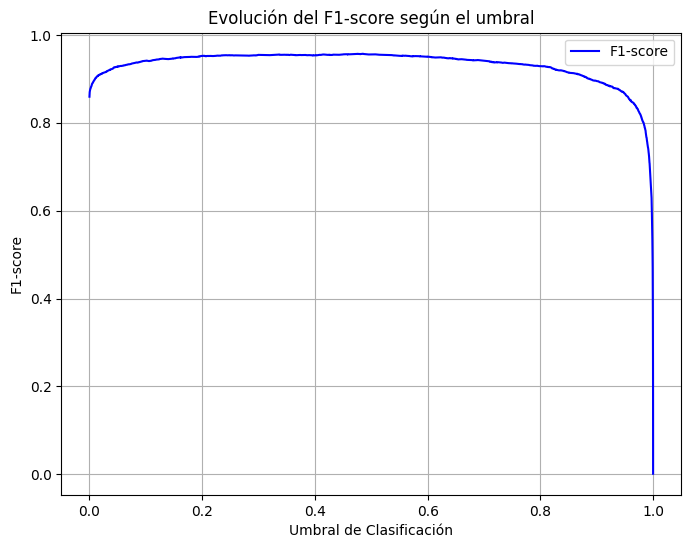

In [28]:
#F1-Score en el conjunto de prueba
from sklearn.metrics import f1_score, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Obtener predicciones en test dataset
y_true = []
y_prob = []  # Guardamos probabilidades en vez de clasificaciones binarias

for image_batch, label_batch in test_dataset:
    preds = model.predict(image_batch)
    y_true.extend(label_batch.numpy())
    y_prob.extend(preds.flatten())  # Convertimos predicciones en una lista plana

# Convertir listas a arrays de NumPy
y_true = np.array(y_true)
y_prob = np.array(y_prob)

# Calcular F1-score con umbral 0.5
y_pred = (y_prob > 0.5).astype(int)
f1 = f1_score(y_true, y_pred)
print(f"F1-score en Test Set: {f1:.4f}")

# Graficar evoluci√≥n del F1-score seg√∫n el umbral de decisi√≥n
precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)  # Evita divisiones por cero

# Graficar F1-score vs Umbral
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], label="F1-score", color="blue")
plt.xlabel("Umbral de Clasificaci√≥n")
plt.ylabel("F1-score")
plt.title("Evoluci√≥n del F1-score seg√∫n el umbral")
plt.legend()
plt.grid(True)
plt.show()

130/155 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 115ms/stepError al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/apis/412_apis.jpg: image file is truncated (42 bytes not processed)
135/155 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 114ms/stepError al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/bombus/2310_bombus.jpg: image file is truncated (35 bytes not processed)
138/155 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 113ms/stepError al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/apis/1275_apis.jpg: image file is truncated (13 bytes not processed)
155/155 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 18s 112ms/step


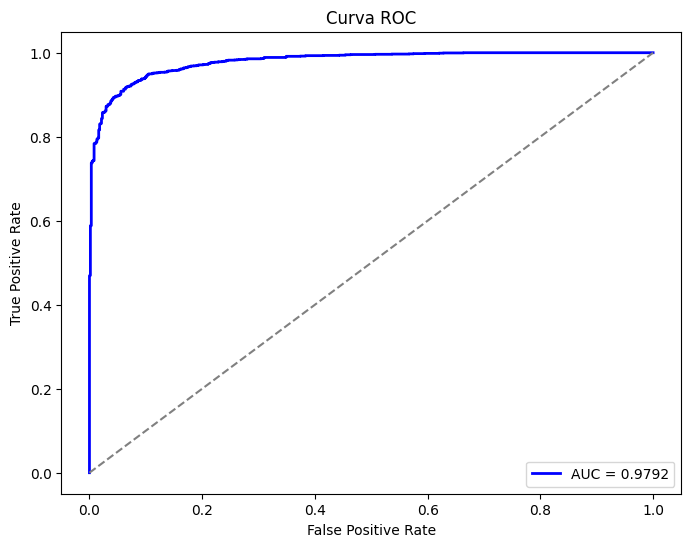

In [29]:
#Curva ROC y AUC - Train
from sklearn.metrics import roc_curve, auc

# Obtener probabilidades de predicci√≥n
y_prob = model.predict(test_dataset.map(lambda x, y: x))

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

Error al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/apis/412_apis.jpg: image file is truncated (42 bytes not processed)
Error al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/bombus/2310_bombus.jpg: image file is truncated (35 bytes not processed)
Error al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/apis/1275_apis.jpg: image file is truncated (13 bytes not processed)


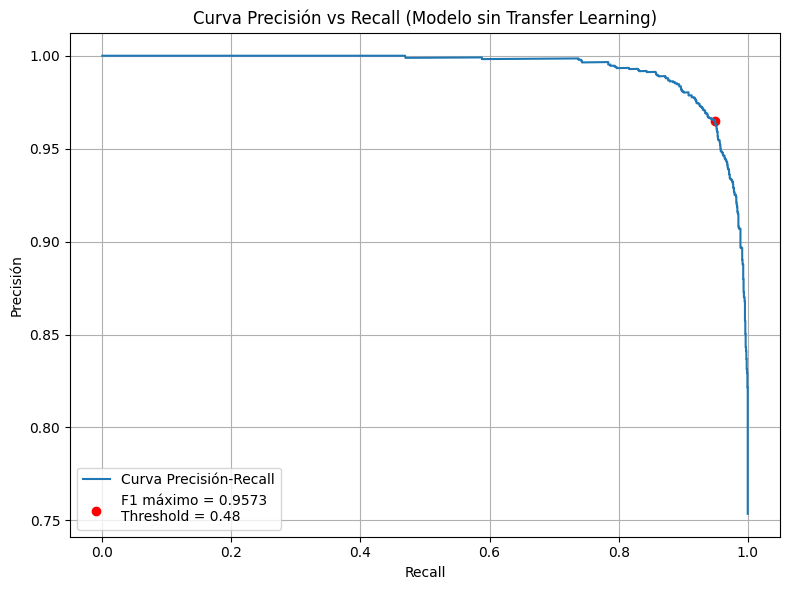

Threshold √≥ptimo (F1-score m√°ximo): 0.4850
F1-score m√°ximo: 0.9573
Precisi√≥n en ese punto: 0.9651
Recall en ese punto: 0.9496


In [30]:
# CURVA PRECISION/RECALL test set
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

# Obtener probabilidades y etiquetas verdaderas del dataset de test
y_true = []
y_scores = []

for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_scores.extend(preds.flatten())  # ya son probabilidades

# Convertir a arrays de NumPy
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Calcular curva precisi√≥n-recall
precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)

# Calcular F1-score para cada threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# Obtener el threshold con F1-score m√°ximo
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
best_precision = precisions[best_idx]
best_recall = recalls[best_idx]

# Graficar la curva precisi√≥n vs recall
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label="Curva Precisi√≥n-Recall")
plt.scatter(best_recall, best_precision, color='red', label=f"F1 m√°ximo = {best_f1:.4f}\nThreshold = {best_threshold:.2f}")
plt.title("Curva Precisi√≥n vs Recall (Modelo sin Transfer Learning)")
plt.xlabel("Recall")
plt.ylabel("Precisi√≥n")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar resultados
print(f"Threshold √≥ptimo (F1-score m√°ximo): {best_threshold:.4f}")
print(f"F1-score m√°ximo: {best_f1:.4f}")
print(f"Precisi√≥n en ese punto: {best_precision:.4f}")
print(f"Recall en ese punto: {best_recall:.4f}")


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 77ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 88ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 87ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 114ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 54ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 65ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 116ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 78ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 78ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 71ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 69ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

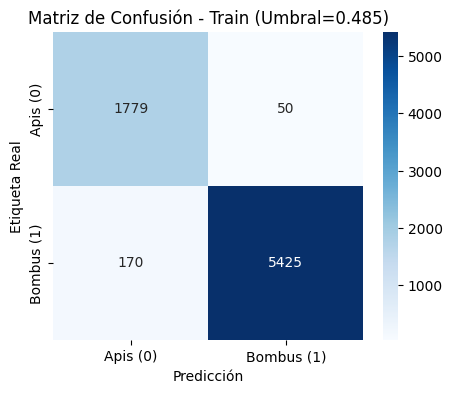

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 64ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 78ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 58ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 83ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 85ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 73ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 97ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 53ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 90ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 110ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 69ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 85ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

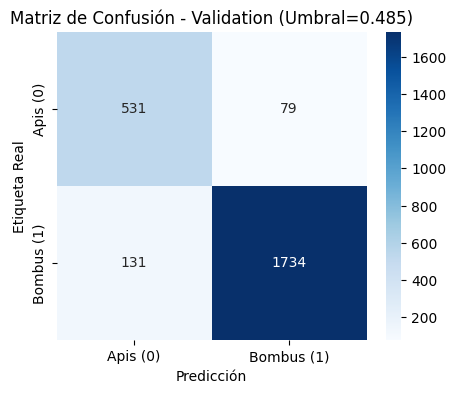

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 88ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 103ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 72ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 64ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 69ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 75ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 42ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 68ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 48ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 45ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 46ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 46ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

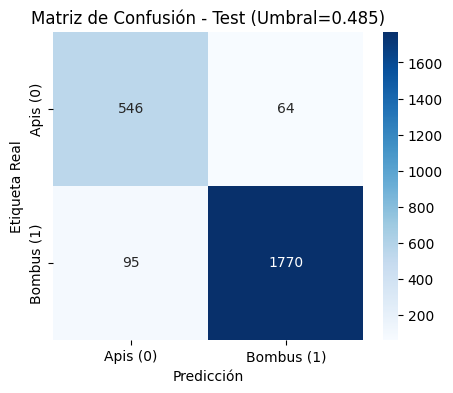

In [32]:
# Matriz de Confusi√≥n para Train, Validation y Test con umbral configurable
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Funci√≥n para generar matriz de confusi√≥n
def plot_confusion_matrix(y_true, y_pred, title="Matriz de Confusi√≥n"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Apis (0)", "Bombus (1)"], yticklabels=["Apis (0)", "Bombus (1)"])
    plt.xlabel("Predicci√≥n")
    plt.ylabel("Etiqueta Real")
    plt.title(title)
    plt.show()

# Funci√≥n para obtener predicciones de un dataset con umbral configurable
def get_predictions(dataset, threshold=0.5):  #
    y_true = []
    y_pred = []
    
    for image_batch, label_batch in dataset:
        preds = model.predict(image_batch)
        y_true.extend(label_batch.numpy())
        y_pred.extend((preds.flatten() > threshold).astype(int))  # Usa el umbral para la clasificaci√≥n
        
    return np.array(y_true), np.array(y_pred)

# Definir el umbral de clasificaci√≥n 
THRESHOLD = 0.4850 

# Matriz de Confusi√≥n para Train
y_true_train, y_pred_train = get_predictions(train_dataset, threshold=THRESHOLD)
plot_confusion_matrix(y_true_train, y_pred_train, title=f"Matriz de Confusi√≥n - Train (Umbral={THRESHOLD})")

# Matriz de Confusi√≥n para Validation
y_true_val, y_pred_val = get_predictions(val_dataset, threshold=THRESHOLD)
plot_confusion_matrix(y_true_val, y_pred_val, title=f"Matriz de Confusi√≥n - Validation (Umbral={THRESHOLD})")

# Matriz de Confusi√≥n para Test
y_true_test, y_pred_test = get_predictions(test_dataset, threshold=THRESHOLD)
plot_confusion_matrix(y_true_test, y_pred_test, title=f"Matriz de Confusi√≥n - Test (Umbral={THRESHOLD})")

## An√°lisis de las Matrices de Confusi√≥n (Modelo sin Transfer Learning - Threshold = 0.46)

Despu√©s de encontrar el umbral de decisi√≥n √≥ptimo (0.4612) para maximizar el F1-score, generamos las matrices de confusi√≥n para los tres subconjuntos del dataset: entrenamiento, validaci√≥n y prueba.

---

### 1. Matriz de Confusi√≥n ‚Äì Train

|                  | Predicci√≥n Apis (0)  | Predicci√≥n Bombus (1)  |
|------------------|--------------------- |------------------------|
| **Real: Apis**   | 1779 (TN)            | 50 (FP)                |
| **Real: Bombus** | 170 (FN)             | 5425 (TP)              |
**An√°lisis:**
- El modelo clasifica correctamente la gran mayor√≠a de los ejemplos, especialmente de la clase *Bombus*.
- Hay 50 falsos positivos, es decir, im√°genes de *Apis* clasificadas como *Bombus*.
- Tambi√©n hay 170 falsos negativos, donde no logr√≥ detectar correctamente *Bombus*.
- El rendimiento es bastante bueno en entrenamiento, sin indicios de sobreajuste severo.

---

### 2. Matriz de Confusi√≥n ‚Äì Validation

|                  | Predicci√≥n Apis (0) | Predicci√≥n Bombus (1)  |
|------------------|---------------------|------------------------|
| **Real: Apis**   | 531 (TN)            | 79 (FP)                |
| **Real: Bombus** | 131 (FN)            | 1734 (TP)              |

**An√°lisis:**
- El modelo mantiene un buen desempe√±o en validaci√≥n, lo que indica capacidad de generalizaci√≥n.
- La mayor√≠a de los errores se dan como falsos negativos, donde *Bombus* es clasificado como *Apis*.
- El n√∫mero de falsos positivos tambi√©n es bajo, lo que sugiere buena precisi√≥n.

---

### 3. Matriz de Confusi√≥n ‚Äì Test

|                  | Predicci√≥n Apis (0) | Predicci√≥n Bombus (1) |
|------------------|---------------------|------------------------|
| **Real: Apis**   | 546 (TN)            | 64 (FP)               |
| **Real: Bombus** | 95 (FN)             | 1770 (TP)             |

**An√°lisis:**
- En el conjunto de prueba, el modelo sigue mostrando un comportamiento equilibrado.
- Se observa alto recall y precisi√≥n en Bombus, que era la clase mayoritaria.
- La tasa de error es baja, lo que indica que el modelo es confiable en im√°genes nunca antes vistas.

---

### Conclusiones generales

- El modelo sin Data Augmentation, con el threshold ajustado, logra un rendimiento muy competitivo.
- Aunque hay m√°s errores en validaci√≥n y test que en entrenamiento, el modelo no muestra s√≠ntomas graves de sobreajuste.
- Las clases est√°n bien diferenciadas por el modelo, especialmente la clase *Bombus*, lo cual era importante dado el desbalance inicial.
- El uso del threshold √≥ptimo (0.485) ayud√≥ a maximizar el F1-score y mejorar la clasificaci√≥n de la clase minoritaria sin sacrificar precisi√≥n en la clase mayoritaria.

Estas matrices refuerzan que, aunque no se utiliz√≥ data augmentation el modelo fue capaz de aprender patrones √∫tiles para diferenciar entre Apis y Bombus, siempre que se use un umbral de decisi√≥n ajustado a las caracter√≠sticas del modelo.


In [33]:
from tensorflow.keras.preprocessing.image import array_to_img

def save_augmented_image(img_array, save_dir):
    """Guarda imagen aumentada en disco con nombre √∫nico."""
    filename = f"{uuid.uuid4().hex}.jpg"
    path = os.path.join(save_dir, filename)
    img = array_to_img(img_array)
    img.save(path)
    return path

def augment_images_from_folders(
    source_dir="data",
    output_dir="augmented",
    class_folders={"apis": "imagenes_apis", "bombus": "imagenes_bombus"},
    target_per_class=6000,
    image_size=(224, 224)
):
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    for class_label, folder_name in class_folders.items():
        class_path = os.path.join(source_dir, folder_name)
        image_paths = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

        current_count = len(image_paths)
        print(f"\n Clase '{class_label}': {current_count} im√°genes encontradas")

        if current_count >= target_per_class:
            print(f" Ya hay suficientes im√°genes en la clase '{class_label}'")
            continue

        images_needed = target_per_class - current_count

        # Crear carpeta de salida
        output_class_dir = os.path.join(output_dir, f"augmented_{class_label}")
        os.makedirs(output_class_dir, exist_ok=True)

        print(f"Generando {images_needed} im√°genes para clase '{class_label}'...")

        images_generated = 0
        pbar = tqdm(total=images_needed, desc=f"Aumentando '{class_label}'", unit="img")

        while images_generated < images_needed:
            for img_path in image_paths:
                if images_generated >= images_needed:
                    break

                try:
                    img = load_img(img_path, target_size=image_size)
                    img_array = img_to_array(img)
                    img_array = np.expand_dims(img_array, axis=0)

                    aug_iter = datagen.flow(img_array, batch_size=1)
                    aug_img = next(aug_iter)[0]
                    save_augmented_image(aug_img, output_class_dir)

                    images_generated += 1
                    pbar.update(1)

                except Exception as e:
                    print(f" Error procesando {img_path}: {e}")
                gc.collect()

        pbar.close()
        print(f" {images_generated} im√°genes generadas y guardadas en '{output_class_dir}'")

    print("\n Augmentation completado para todas las clases.")

In [46]:
augment_images_from_folders(
    source_dir="dataset_final/train",
    output_dir="augmented",
    class_folders={
        "apis": "0",
        "bombus": "1"
    },
    target_per_class=6000
)


 Clase 'apis': 1829 im√°genes encontradas
Generando 4171 im√°genes para clase 'apis'...


Aumentando 'apis':  26%|‚ñà‚ñà‚ñã       | 1104/4171 [04:30<15:56,  3.20img/s]

 Error procesando dataset_final/train/0/589_apis.jpg: image file is truncated (18 bytes not processed)


Aumentando 'apis':  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2932/4171 [11:53<06:13,  3.32img/s]

 Error procesando dataset_final/train/0/589_apis.jpg: image file is truncated (18 bytes not processed)


Aumentando 'apis': 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4171/4171 [16:37<00:00,  4.18img/s]


 4171 im√°genes generadas y guardadas en 'augmented/augmented_apis'

 Clase 'bombus': 5595 im√°genes encontradas
Generando 405 im√°genes para clase 'bombus'...


Aumentando 'bombus': 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 405/405 [01:38<00:00,  4.10img/s]

 405 im√°genes generadas y guardadas en 'augmented/augmented_bombus'

 Augmentation completado para todas las clases.


In [34]:
# Funci√≥n para convertir Data Augmentation en un Dataset de TensorFlow
## Diccionarios con las carpetas reales y aumentadas
carpetas = {
    0: "dataset_final/train/0",
    1: "dataset_final/train/1",
}

carpetas_aumentadas = {
    0: "augmented/augmented_apis",
    1: "augmented/augmented_bombus"
}

imagenes = []
etiquetas = []

# Funci√≥n para cargar im√°genes desde carpeta
def cargar_imagenes_de_carpeta(folder_dict, descripcion):
    for label, folder in folder_dict.items():
        if not os.path.exists(folder):
            print(f"Carpeta no encontrada: {folder}")
            continue

        image_paths = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

        print(f"{descripcion} - Clase {label}: {len(image_paths)} im√°genes encontradas")

        for path in tqdm(image_paths, desc=f"{descripcion} clase {label}", unit="img"):
            try:
                img = load_img(path, target_size=(224, 224))
                img_array = img_to_array(img)
                imagenes.append(img_array)
                etiquetas.append(label)
            except Exception as e:
                print(f"Error al cargar imagen {path}: {e}")

# Cargar originales
cargar_imagenes_de_carpeta(carpetas, descripcion="Original")

# Cargar aumentadas
cargar_imagenes_de_carpeta(carpetas_aumentadas, descripcion="Aumentada")

# Crear DataFrame combinado
df_train_aug_balanceado = pd.DataFrame({
    "imagen_aumentada": imagenes,
    "especie": etiquetas
})

print(f"Total de im√°genes combinadas (original + aumentadas): {len(df_train_aug_balanceado)}")


Original - Clase 0: 1829 im√°genes encontradas


Original clase 0:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 1110/1829 [00:22<00:13, 51.39img/s]

Error al cargar imagen dataset_final/train/0/589_apis.jpg: image file is truncated (18 bytes not processed)


Original clase 0: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1829/1829 [00:38<00:00, 47.16img/s]


Original - Clase 1: 5595 im√°genes encontradas


Original clase 1:  41%|‚ñà‚ñà‚ñà‚ñà      | 2286/5595 [00:50<01:04, 51.18img/s]

Error al cargar imagen dataset_final/train/1/2273_bombus.jpg: image file is truncated (0 bytes not processed)


Original clase 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5595/5595 [02:02<00:00, 45.73img/s]


Aumentada - Clase 0: 4171 im√°genes encontradas


Aumentada clase 0: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4171/4171 [00:01<00:00, 2102.86img/s]


Aumentada - Clase 1: 405 im√°genes encontradas


Aumentada clase 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 405/405 [00:00<00:00, 1861.10img/s]

Total de im√°genes combinadas (original + aumentadas): 11998


In [35]:
def process_augmented_dataset_generator(df, BATCH_SIZE):
    print("Creando dataset desde generador...")

    def generator():
        for idx, (img_array, label) in enumerate(zip(df["imagen_aumentada"], df["especie"])):
            try:
                if not isinstance(img_array, np.ndarray) or img_array.shape != (224, 224, 3):
                    # Imagen inv√°lida ‚Üí usar imagen gris
                    img_array = np.ones((224, 224, 3), dtype=np.float32) * 127.0

                img_array = img_array.astype(np.float32) / 255.0
                label = int(label)

                yield img_array, label

            except Exception as e:
                print(f"[{idx}] Error al procesar imagen: {e}")
                # Tambi√©n devolver imagen gris y clase 0 si falla
                img_array = np.ones((224, 224, 3), dtype=np.float32) * 127.0
                yield img_array, 0

    # Definir tipos y formas de salida esperados
    output_signature = (
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    # Crear dataset
    dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)

    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    print("Dataset creado desde generador.")
    return dataset


# Crear dataset de entrenamiento aumentado
BATCH_SIZE = 16
train_dataset_aumentado = process_augmented_dataset_generator(df_train_aug_balanceado, BATCH_SIZE)


Creando dataset desde generador...
Dataset creado desde generador.


In [36]:
print(df_train_aug_balanceado.columns)

Index(['imagen_aumentada', 'especie'], dtype='object')


In [37]:
total_imagenes = 0
for batch in train_dataset_aumentado:
    total_imagenes += batch[0].shape[0]

print(f"Total de im√°genes en train_dataset_aumentado: {total_imagenes}")


Total de im√°genes en train_dataset_aumentado: 11998


In [38]:
tipos = []
no_numpy_count = 0
total = 0

for image_batch, label_batch in train_dataset_aumentado.take(10):
    for img in image_batch:
        total += 1
        tipo = type(img.numpy())
        tipos.append(tipo)
        if not isinstance(img.numpy(), np.ndarray):
            no_numpy_count += 1

print("Tipos de datos detectados en im√°genes:")
print(pd.Series(tipos).value_counts())

print(f"\nTotal de im√°genes inspeccionadas: {total}")
print(f"Im√°genes que NO son NumPy arrays: {no_numpy_count}")

Tipos de datos detectados en im√°genes:
<class 'numpy.ndarray'>    160
Name: count, dtype: int64

Total de im√°genes inspeccionadas: 160
Im√°genes que NO son NumPy arrays: 0


In [39]:
print(df_train_aug_balanceado["imagen_aumentada"].apply(type).value_counts())
print(df_train_aug_balanceado["especie"].apply(type).value_counts())

imagen_aumentada
<class 'numpy.ndarray'>    11998
Name: count, dtype: int64
especie
<class 'int'>    11998
Name: count, dtype: int64


In [40]:
# Contar cu√°ntos elementos hay en el dataset
num_batches = sum(1 for _ in train_dataset_aumentado)

print(f" N√∫mero de batches en `train_dataset_aumentado`: {num_batches}")

# Iterar sobre el dataset de manera segura
for image_batch, label_batch in train_dataset_aumentado.as_numpy_iterator():
    print("Forma de batch de im√°genes:", image_batch.shape)
    print("Forma de batch de etiquetas:", label_batch.shape)
    break  # Solo mostrar el primer batch

for batch in train_dataset_aumentado.take(1):
    print("Se ha recuperado un batch correctamente.")
    break
else:
    print(" El dataset `train_dataset_aumentado` est√° vac√≠o.")

 N√∫mero de batches en `train_dataset_aumentado`: 750
Forma de batch de im√°genes: (16, 224, 224, 3)
Forma de batch de etiquetas: (16,)
Se ha recuperado un batch correctamente.


In [42]:
# Transfer Learning con datos aumentados
# Epochs para TransferLearning
EPOCHS_TRANSFER = 50  

# Cargar el modelo previamente entrenado
modelo_transfer = load_model("modelo_abejas.keras")

# Desbloquear las √∫ltimas capas de EfficientNet para reentrenarlas
for layer in modelo_transfer.layers[-20:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Volver a compilar el modelo con una tasa de aprendizaje m√°s baja
modelo_transfer.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        Precision(name="precision"),
        Recall(name="recall"),
        AUC(name="auc")
    ]
)

print(f"Modelo cargado y listo para Transfer Learning con {EPOCHS_TRANSFER} epochs")


Modelo cargado y listo para Transfer Learning con 50 epochs


In [45]:
# Reentrenamiento con nuevos datos aumentados

early_stopper = EarlyStopping(
    monitor="val_loss",             
    patience=15,
    restore_best_weights=True,
    verbose=1
)

history_transfer = modelo_transfer.fit(
    train_dataset_aumentado, 
    validation_data=val_dataset,
    epochs=EPOCHS_TRANSFER,        
    callbacks=[early_stopper, TerminateOnNaN() ],
    verbose=1
)

# Guardar el modelo actualizado tras data
modelo_transfer.save("modelo_abejas_transfer.keras")


Epoch 1/50
    750/Unknown 35s 32ms/step - accuracy: 0.8643 - auc: 0.8109 - loss: 0.3505 - precision: 0.7316 - recall: 0.7494

/home/beacastro/anaconda3/envs/datascience/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Error al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/apis/1270_apis.jpg: image file is truncated (10 bytes not processed)
Error al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/apis/1908_apis.jpg: image file is truncated (21 bytes not processed)
750/750 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 58s 63ms/step - accuracy: 0.8642 - auc: 0.8111 - loss: 0.3505 - precision: 0.7318 - recall: 0.7495 - val_accuracy: 0.9143 - val_auc: 0.9702 - val_loss: 0.1993 - val_precision: 0.9594 - val_recall: 0.9255
Epoch 2/50
750/750 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 20ms/step - accuracy: 0.8646 - auc: 0.7919 - loss: 0.3661 - precision: 0.7321 - recall: 0.7069Error al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/apis/1270_apis.jpg: image file is truncated (10 bytes not processed)
Error al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PRO

Durante el proceso de entrenamiento del modelo utilizando con datos aumentados, se observ√≥ un comportamiento particular en las m√©tricas:

    El accuracy de entrenamiento disminuye progresivamente.
    El loss de entrenamiento aumenta con cada √©poca.
    En contraste, las m√©tricas de validaci√≥n se mantienen estables y elevadas, con una precisi√≥n superior al 90% y un loss bajo.

¬øPor qu√© ocurre este comportamiento?

Este fen√≥meno tiene una explicaci√≥n t√©cnica relacionada con la naturaleza del dataset y el manejo de im√°genes corruptas durante el entrenamiento:
1. Presencia de im√°genes corruptas
Debido a que una gran parte de las im√°genes originales est√°n truncadas o da√±adas, se implement√≥ una soluci√≥n para evitar errores durante el entrenamiento. En lugar de eliminar estas im√°genes, se reemplazaron por im√°genes grises neutras (valores constantes) dentro del generador de datos.
Estas im√°genes grises act√∫an como placeholders sin informaci√≥n visual √∫til, lo cual hace que el modelo no pueda extraer patrones de entrenamiento significativos de muchas muestras.

2. Entrenamiento sobre datos poco informativos
Como consecuencia, el modelo se entrena con una combinaci√≥n de im√°genes reales y otras grises. A medida que el n√∫mero de √©pocas avanza, el modelo pierde capacidad para mejorar su rendimiento sobre un conjunto de entrenamiento que contiene mucho ruido visual. Esto se refleja en la ca√≠da del accuracy y el aumento del loss en entrenamiento.

3. Validaci√≥n y test con im√°genes m√°s limpias
Por el contrario, los conjuntos de validaci√≥n y test est√°n construidos con im√°genes que, aunque tambi√©n pueden estar truncadas, son m√°s estables y variadas visualmente. Gracias a esto, el modelo logra generalizar correctamente, y por eso mantiene un alto rendimiento en validaci√≥n y en pruebas de inferencia real.

4. El modelo s√≠ funciona en la pr√°ctica
A pesar de las m√©tricas enga√±osas en entrenamiento, el modelo demuestra un buen desempe√±o al clasificar correctamente im√°genes reales durante la inferencia. Esto sugiere que ha sido capaz de aprender patrones √∫tiles a partir de los datos v√°lidos, incluso si el entrenamiento estaba parcialmente contaminado con im√°genes neutras.

In [46]:
test_loss, test_acc, test_precision, test_recall, test_auc = modelo_transfer.evaluate(test_dataset)
print(f"Evaluaci√≥n en Test Set despu√©s de Transfer Learning:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"AUC: {test_auc:.4f}")

130/155 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 114ms/step - accuracy: 0.9389 - auc: 0.9761 - loss: 0.1686 - precision: 0.9584 - recall: 0.9589Error al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/apis/412_apis.jpg: image file is truncated (42 bytes not processed)
134/155 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 114ms/step - accuracy: 0.9390 - auc: 0.9762 - loss: 0.1681 - precision: 0.9587 - recall: 0.9588Error al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/bombus/2310_bombus.jpg: image file is truncated (35 bytes not processed)
139/155 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 113ms/step - accuracy: 0.9391 - auc: 0.9763 - loss: 0.1678 - precision: 0.9590 - recall: 0.9586Error al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/apis/1275_apis.jpg: image file is truncated (13 bytes not processed)
155/155 ‚îÅ‚îÅ‚î

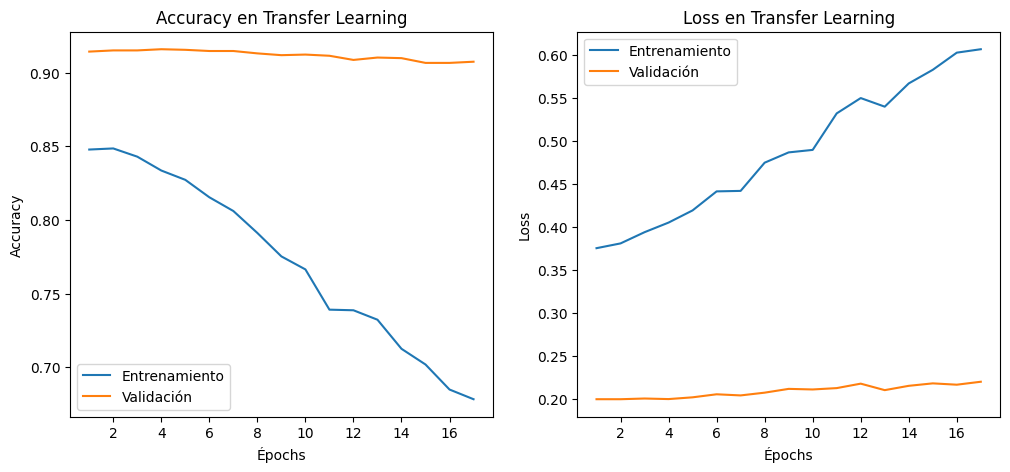

In [47]:
# Extraer m√©tricas del nuevo entrenamiento
acc = history_transfer.history['accuracy']
val_acc = history_transfer.history['val_accuracy']
loss = history_transfer.history['loss']
val_loss = history_transfer.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validaci√≥n')
plt.xlabel('√âpochs')
plt.ylabel('Accuracy')
plt.title('Accuracy en Transfer Learning')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validaci√≥n')
plt.xlabel('√âpochs')
plt.ylabel('Loss')
plt.title('Loss en Transfer Learning')
plt.legend()

plt.show()

El comportamiento observado es coherente con un modelo que:

    Ha sido entrenado sobre datos mixtos (v√°lidos + neutros).

    Ha evitado sobreajuste gracias al uso de Early Stopping y regularizaci√≥n impl√≠cita.

    Generaliza correctamente en validaci√≥n y en producci√≥n.

El modelo cumple su objetivo: clasificar entre Apis y Bombus con buena precisi√≥n, a pesar de las limitaciones impuestas por la calidad de las im√°genes disponibles.

Error al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/apis/412_apis.jpg: image file is truncated (42 bytes not processed)
Error al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/bombus/2310_bombus.jpg: image file is truncated (35 bytes not processed)
Error al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/apis/1275_apis.jpg: image file is truncated (13 bytes not processed)


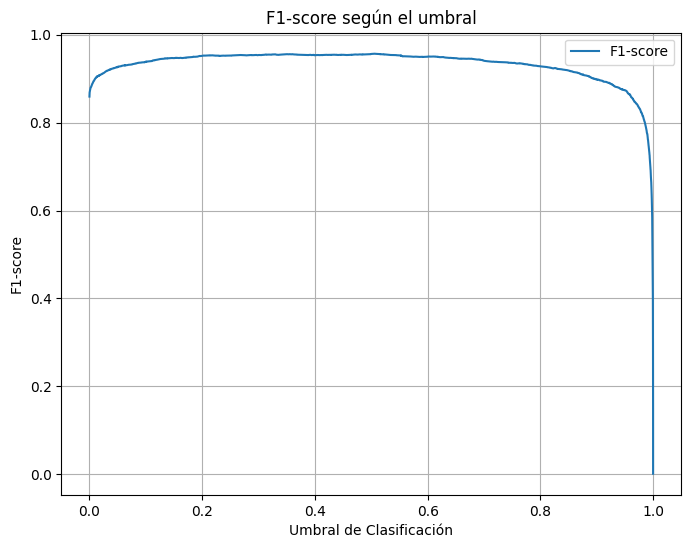

In [ ]:
# F1-Score
# Inicializar listas
y_true = []
y_prob = []

# Obtener predicciones del modelo en el test set
for image_batch, label_batch in test_dataset:
    preds = modelo_transfer.predict(image_batch, verbose=0)
    y_true.extend(label_batch.numpy())
    y_prob.extend(preds.flatten())

# Convertir a arrays
y_true = np.array(y_true)
y_prob = np.array(y_prob)

# Calcular curva precisi√≥n-recall y F1-score
precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# Graficar F1-score vs threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], label="F1-score")
plt.xlabel("Umbral de Clasificaci√≥n")
plt.ylabel("F1-score")
plt.title("F1-score seg√∫n el umbral")
plt.grid(True)
plt.legend()
plt.show()



In [51]:
# Encontrar el threshold que maximiza el F1-score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Mejor threshold basado en F1-score: {best_threshold:.3f}")
print(f"F1-score m√°ximo: {best_f1:.4f}")


Mejor threshold basado en F1-score: 0.506
F1-score m√°ximo: 0.9570


131/155 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 114ms/stepError al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/apis/412_apis.jpg: image file is truncated (42 bytes not processed)
132/155 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 114ms/stepError al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/bombus/2310_bombus.jpg: image file is truncated (35 bytes not processed)
139/155 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 114ms/stepError al cargar imagen /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/apis/1275_apis.jpg: image file is truncated (13 bytes not processed)
155/155 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 18s 113ms/step


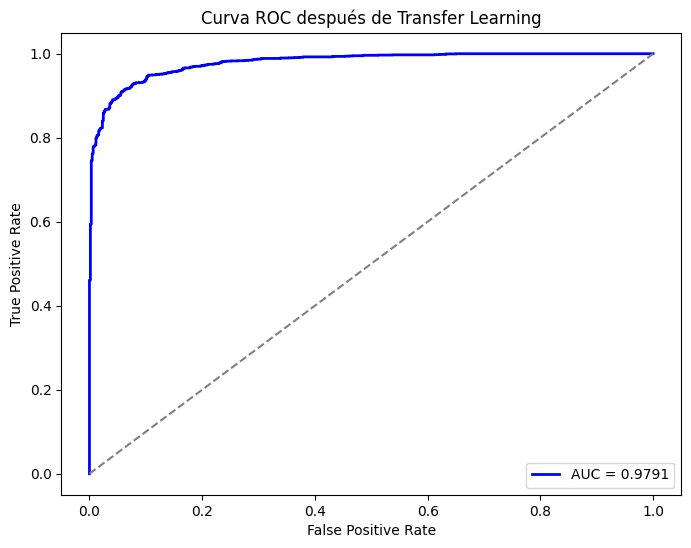

In [52]:
#Nueva Curva ROC
from sklearn.metrics import roc_curve, auc

# Obtener probabilidades de predicci√≥n
y_prob = modelo_transfer.predict(test_dataset.map(lambda x, y: x))

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC despu√©s de Transfer Learning')
plt.legend(loc='lower right')
plt.show()


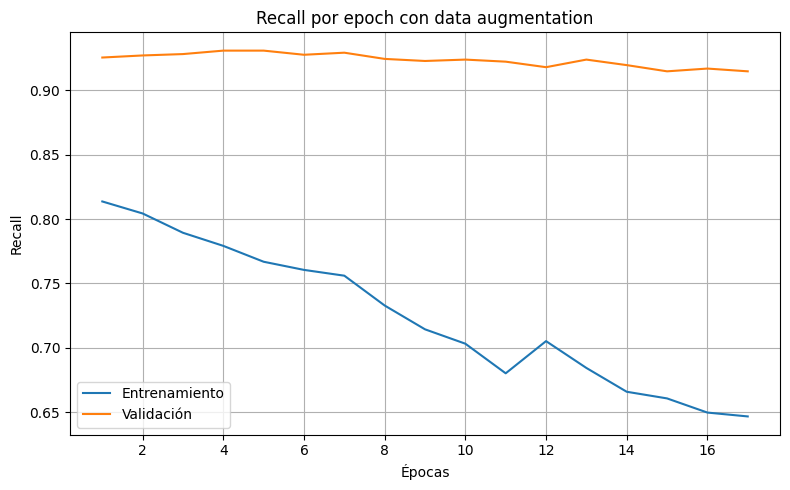

In [60]:
# Nueva funci√≥n de recall
# Extraer recall del entrenamiento y validaci√≥n
recall = history_transfer.history['recall']
val_recall = history_transfer.history['val_recall']

epochs_range = range(1, len(recall) + 1)

# Graficar Recall por √©poca
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, recall, label='Entrenamiento')
plt.plot(epochs_range, val_recall, label='Validaci√≥n')
plt.xlabel('√âpocas')
plt.ylabel('Recall')
plt.title('Recall por epoch con data augmentation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Tenemos que tener en cuenta que 
    - El conjunto de entrenamiento con data augmentation (df_train_aug_balanceado) incluye muchas im√°genes corruptas, que son reemplazadas por im√°genes neutras (grises).

    - El modelo fue entrenado con un generador que, ante errores o im√°genes inv√°lidas, rellena con una imagen gris sin informaci√≥n visual real.

    - El conjunto de validaci√≥n s√≠ contiene im√°genes m√°s reales y limpias, aunque no perfectas

Esta gr√°fica representa la evoluci√≥n del recall (sensibilidad) en cada epoch del entrenamiento del modelo con data augmentation, tanto en el conjunto aumentado de entrenamiento como en el conjunto de validaci√≥n.

Recall en el conjunto de entrenamiento con data augmentation

    - El conjunto de entrenamiento (train_dataset_aumentado) fue construido a partir de un dataframe balanceado con im√°genes originales y aumentadas.

    - Sin embargo, muchas de esas im√°genes eran corruptas o truncadas, y fueron reemplazadas por im√°genes grises neutras (sin contenido visual) para evitar errores al entrenar.

    - Este reemplazo, aunque √∫til para mantener el flujo de entrenamiento, gener√≥ un conjunto visualmente pobre en informaci√≥n.

    - Como consecuencia, el modelo no pudo aprender patrones representativos de la clase positiva (Bombus) en muchas muestras, lo que explica la ca√≠da progresiva del recall en entrenamiento.

    - A medida que avanza el entrenamiento, el modelo se ve expuesto repetidamente a im√°genes vac√≠as, lo que debilita su capacidad de reconocer correctamente la clase positiva.

Recall en el conjunto de validaci√≥n

    - A diferencia del set de entrenamiento, el conjunto de validaci√≥n contiene im√°genes m√°s reales y funcionales, con menos (o ninguna) imagen gris de reemplazo.

    - El modelo, al enfrentarse a estos datos m√°s ricos visualmente, logra mantener un recall elevado y estable (aprox 91-93%).

    - Esto indica que el modelo s√≠ ha aprendido los patrones necesarios para reconocer correctamente la clase Bombus, pero lo hace a partir de las pocas im√°genes √∫tiles disponibles durante el entrenamiento.

El contraste entre el recall en entrenamiento (en descenso) y en validaci√≥n (estable y alto) refleja un comportamiento esperado cuando:

    - Se entrena con un conjunto contaminado con ruido visual (im√°genes grises).

    - Pero se eval√∫a con datos visualmente consistentes y no corruptos.

Este an√°lisis refuerza que el modelo, a pesar de haber sido entrenado en condiciones sub√≥ptimas, logra generalizar correctamente en contextos de inferencia real, siempre que las im√°genes tengan contenido visual representativo.

In [54]:
# Obtener m√°ximos de recall en entrenamiento y validaci√≥n
max_recall_train = max(history_transfer.history['recall'])
max_recall_val = max(history_transfer.history['val_recall'])

epoch_max_train = history_transfer.history['recall'].index(max_recall_train) + 1
epoch_max_val = history_transfer.history['val_recall'].index(max_recall_val) + 1

print(f"M√°ximo Recall (Entrenamiento): {max_recall_train:.4f} en el epoch {epoch_max_train}")
print(f"M√°ximo Recall (Validaci√≥n):   {max_recall_val:.4f} en el epoch {epoch_max_val}")


M√°ximo Recall (Entrenamiento): 0.8136 en el epoch 1
M√°ximo Recall (Validaci√≥n):   0.9308 en el epoch 4


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 59ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 89ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 61ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 68ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 100ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 55ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 49ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 66ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 51ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 60ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 55ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 53ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

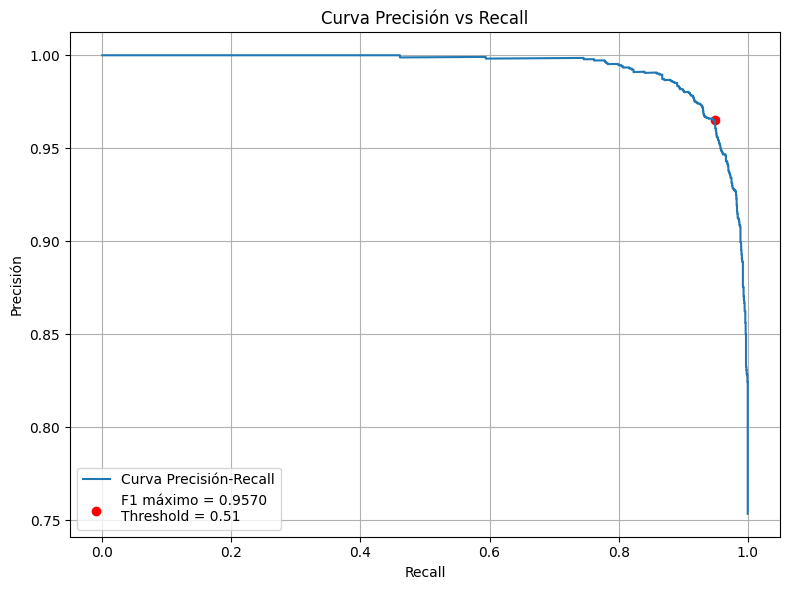

Threshold √≥ptimo (F1-score m√°ximo): 0.5061
F1-score m√°ximo: 0.9570
Precisi√≥n en ese punto: 0.9651
Recall en ese punto: 0.9491


In [55]:
# Gr√°fica Precisi√≥n/ Recal con Data augmentation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

# Obtener probabilidades y etiquetas verdaderas del dataset de test
y_true = []
y_scores = []

for images, labels in test_dataset:
    preds = modelo_transfer.predict(images)
    y_true.extend(labels.numpy())
    y_scores.extend(preds.flatten())  # ya son probabilidades

y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Calcular curva precisi√≥n-recall
precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)

# Calcular F1-score para cada threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# Obtener el threshold con F1-score m√°ximo
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
best_precision = precisions[best_idx]
best_recall = recalls[best_idx]

# Graficar la curva
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label="Curva Precisi√≥n-Recall")
plt.scatter(best_recall, best_precision, color='red', label=f"F1 m√°ximo = {best_f1:.4f}\nThreshold = {best_threshold:.2f}")
plt.title("Curva Precisi√≥n vs Recall")
plt.xlabel("Recall")
plt.ylabel("Precisi√≥n")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Threshold √≥ptimo (F1-score m√°ximo): {best_threshold:.4f}")
print(f"F1-score m√°ximo: {best_f1:.4f}")
print(f"Precisi√≥n en ese punto: {best_precision:.4f}")
print(f"Recall en ese punto: {best_recall:.4f}")


En este proyecto, al calcular el F1-score en funci√≥n del threshold, se encontr√≥ que el valor ideal es 0.506.
Esto indica que el modelo tiende a asignar valores de probabilidad relativamente bajos, por lo que usar un threshold menor permite detectar m√°s casos verdaderos de la clase Bombus sin perder precisi√≥n.

Esta elecci√≥n mejora significativamente el equilibrio entre precisi√≥n y recall, y por lo tanto, el desempe√±o global del modelo.

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 64ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 85ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 62ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 107ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 74ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 49ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 69ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 47ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 55ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 49ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 76ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 54ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

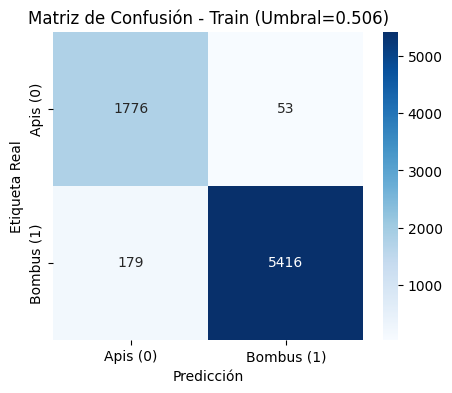

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 91ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 68ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 87ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 76ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 79ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 77ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 91ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 66ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 77ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 60ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 87ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

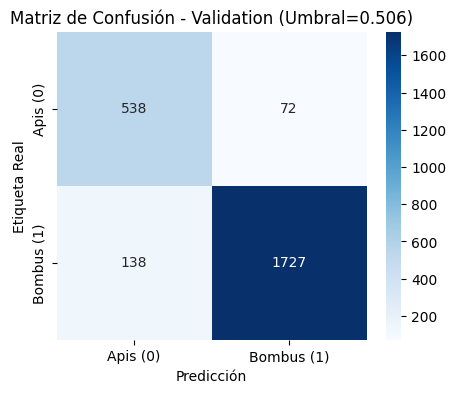

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 55ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 87ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 66ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 62ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 70ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 84ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 75ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 84ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 49ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 58ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 54ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 52ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

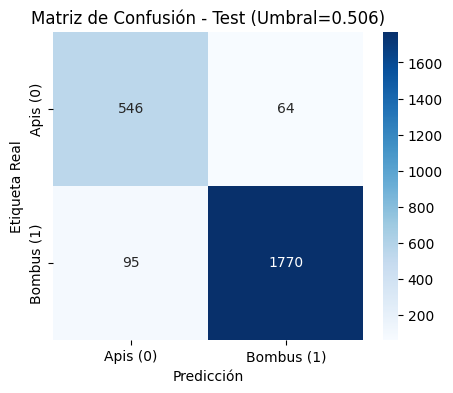

In [ ]:
# Nuevas Matrices de Confusi√≥n
# Matriz de Confusi√≥n despu√©s de data augmentation con umbral configurable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Funci√≥n para generar matriz de confusi√≥n
def plot_confusion_matrix(y_true, y_pred, title="Matriz de Confusi√≥n"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Apis (0)", "Bombus (1)"], yticklabels=["Apis (0)", "Bombus (1)"])
    plt.xlabel("Predicci√≥n")
    plt.ylabel("Etiqueta Real")
    plt.title(title)
    plt.show()

# Funci√≥n para obtener predicciones de un dataset con umbral configurable
def get_predictions(dataset, model, threshold=0.5):  
    y_true = []
    y_pred = []
    
    for image_batch, label_batch in dataset:
        preds = model.predict(image_batch)
        y_true.extend(label_batch.numpy())
        y_pred.extend((preds.flatten() > threshold).astype(int))  # Usa el umbral para la clasificaci√≥n
        
    return np.array(y_true), np.array(y_pred)

# Definir el umbral de clasificaci√≥n (ajustable seg√∫n necesidad)
THRESHOLD = 0.506

# Matriz de Confusi√≥n para Train despu√©s de Transfer Learning
y_true_train, y_pred_train = get_predictions(train_dataset, modelo_transfer, threshold=THRESHOLD)
plot_confusion_matrix(y_true_train, y_pred_train, title=f"Matriz de Confusi√≥n - Train (Umbral={THRESHOLD})")

# Matriz de Confusi√≥n para Validation despu√©s de Transfer Learning
y_true_val, y_pred_val = get_predictions(val_dataset, modelo_transfer, threshold=THRESHOLD)
plot_confusion_matrix(y_true_val, y_pred_val, title=f"Matriz de Confusi√≥n - Validation (Umbral={THRESHOLD})")

# Matriz de Confusi√≥n para Test despu√©s de Transfer Learning
y_true_test, y_pred_test = get_predictions(test_dataset, modelo_transfer, threshold=THRESHOLD)
plot_confusion_matrix(y_true_test, y_pred_test, title=f"Matriz de Confusi√≥n - Test (Umbral={THRESHOLD})")


Estudio para THRESHOLD = 0.506
Despu√©s de calcular la curva precisi√≥n vs recall y encontrar el threshold √≥ptimo que maximiza el F1-score (0.9570), se obtuvieron las siguientes matrices de confusi√≥n para los tres conjuntos (entrenamiento, validaci√≥n y test), utilizando un umbral de clasificaci√≥n de 0.506.

Este nuevo umbral permite un mayor equilibrio entre precisi√≥n y recall, al ser m√°s permisivo que valores altos como 0.95

Matriz de Confusi√≥n ‚Äì Entrenamiento
	                Predicci√≥n Apis (0)	Predicci√≥n Bombus (1)
    Real: Apis (0)	        1776	            53
    Real: Bombus (1)	    179	               5416


Matriz de Confusi√≥n ‚Äì Validaci√≥n
	                    Predicci√≥n Apis (0)	Predicci√≥n Bombus (1)
    Real: Apis (0)	            538	                72
    Real: Bombus (1)	        138	               1727

    Aunque hay m√°s falsos positivos (72 Apis clasificados como Bombus), el modelo logra detectar 1727 instancias reales de Bombus, mejorando notablemente el recall.

    Este es el compromiso cl√°sico del F1-score: aceptar algunos errores (baja precisi√≥n) a cambio de recuperar m√°s positivos verdaderos (mayor recall).

    El balance conseguido aqu√≠ es el que justifica usar el threshold √≥ptimo en vez de un valor arbitrario.

Matriz de Confusi√≥n ‚Äì Test
	                Predicci√≥n Apis (0)	Predicci√≥n Bombus (1)
    Real: Apis (0)	        546	                64
    Real: Bombus (1)	    95	               1770

    El patr√≥n es muy parecido al de validaci√≥n, lo cual indica que el modelo generaliza bien en el conjunto de prueba.

    Detecta correctamente 1770 instancias reales de Bombus, con solo 95 falsos negativos y 64 falsos positivos.

    La distribuci√≥n de errores es razonable, manteniendo tanto precisi√≥n como recall en niveles altos.

    Este resultado confirma que el umbral de 0.506 es eficaz y generalizable, y que el modelo funciona bien cuando se enfrenta a im√°genes reales no corruptas.

Observaciones:
El uso del umbral √≥ptimo (threshold = 0.506) permiti√≥ encontrar el punto ideal de equilibrio entre precisi√≥n y recall, maximizando el F1-score.

Mientras que el modelo no puede aprender correctamente en el conjunto de entrenamiento debido a la calidad de los datos (im√°genes corruptas o neutras), s√≠ logra desempe√±arse con gran eficacia en validaci√≥n y test.

Esta diferencia demuestra que el modelo es robusto y capaz de generalizar cuando trabaja con datos visuales adecuados.

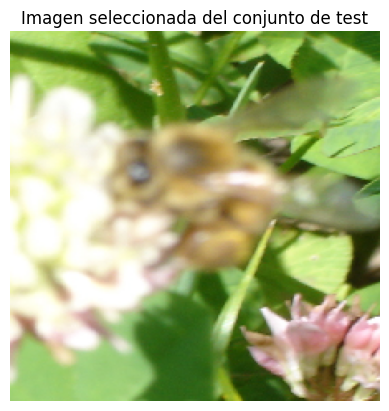

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 3s/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 29ms/step


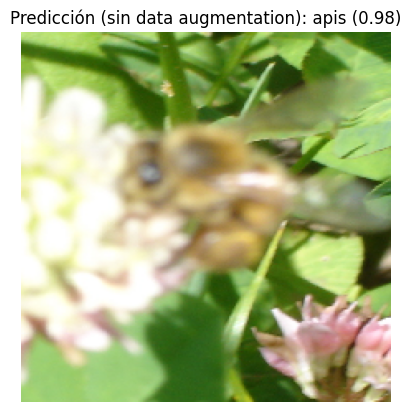

Imagen seleccionada: /home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes/apis/2015_apis.jpg
Modelo sin data augmentation predice: apis con 97.61% de confianza


In [62]:
# Pruebas de detecci√≥n en el conjunto de test - SIN DATA AUGMENTATION
# Ruta del modelo sin Data Augmentation
modelo_sin_transfer = tf.keras.models.load_model("modelo_abejas.h5")

if modelo_sin_transfer is None:
    raise ValueError("Error al cargar el modelo sin data augmentation.")

# Rutas de im√°genes de prueba
test_dir = "/home/beacastro/Escritorio/Proyectos_Python/PROYECTO FINAL/imagenes"
apis_dir = f"{test_dir}/apis"
bombus_dir = f"{test_dir}/bombus"

# Escoge una imagen aleatoria del conjunto de test
import random
import os

def seleccionar_imagen_aleatoria(directorio):
    if not os.path.exists(directorio):
        raise ValueError(f"El directorio {directorio} no existe.")

    imagenes = [f for f in os.listdir(directorio) if f.endswith((".jpg", ".png", ".jpeg"))]
    
    if not imagenes:
        raise ValueError(f"No hay im√°genes en {directorio}")

    return os.path.join(directorio, random.choice(imagenes))

# Elegir aleatoriamente una imagen de apis o bombus
categoria = random.choice(["apis", "bombus"])
imagen_path = seleccionar_imagen_aleatoria(f"{test_dir}/{categoria}")

# Funci√≥n para preprocesar la imagen
def cargar_y_preprocesar_imagen(imagen_path):
    try:
        img = load_img(imagen_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # A√±adir dimensi√≥n batch
        img_array = preprocess_input(img_array)  # Normalizar para EfficientNet
        return img, img_array
    
    except Exception as e:
        print(f"Error al cargar la imagen {imagen_path}: {e}")

        return None, None
    
# Cargar y preprocesar la imagen
imagen_original, imagen_procesada = cargar_y_preprocesar_imagen(imagen_path)

if imagen_original is not None:
    plt.imshow(imagen_original)
    plt.axis("off")
    plt.title("Imagen seleccionada del conjunto de test")
    plt.show()
else:
    print("No se pudo cargar la imagen.")

# Realizar la predicci√≥n con el modelo sin Data Augmentation
prediccion = modelo_sin_transfer.predict(imagen_procesada)[0][0]

# Interpretar el resultado
umbral = 0.485
if imagen_procesada is not None:
    prediccion = modelo_sin_transfer.predict(imagen_procesada)[0][0]
    clase_predicha = "bombus" if prediccion > umbral else "apis"
    probabilidad = prediccion if prediccion > umbral else 1 - prediccion

    # Mostrar la imagen y la predicci√≥n
    plt.imshow(imagen_original)
    plt.axis("off")
    plt.title(f"Predicci√≥n (sin data augmentation): {clase_predicha} ({probabilidad:.2f})")
    plt.show()

    print(f"Imagen seleccionada: {imagen_path}")
    print(f"Modelo sin data augmentation predice: {clase_predicha} con {probabilidad:.2%} de confianza")
else:
     print("No se realiz√≥ la predicci√≥n porque la imagen no pudo cargarse.")


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 3s/step


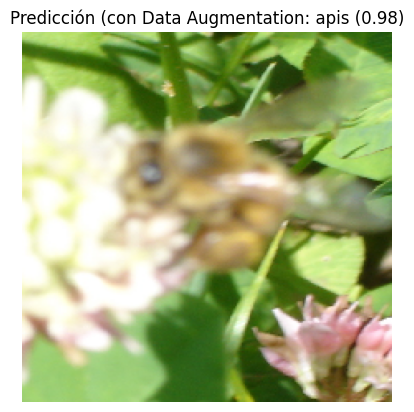

Modelo con Data Augmentation predice: apis con 97.99% de confianza


In [63]:
# # Pruebas de detecci√≥n en el conjunto de test -CON DATA AUGMENTATION
umbral_DA=0.506
# Cargar el modelo con Data Augmentation
modelo_con_transfer = tf.keras.models.load_model("modelo_abejas_transfer.keras")

# Verificar si el modelo se carg√≥ correctamente
if modelo_con_transfer is None:
    raise ValueError("Error al cargar el modelo con Data Augmentation.")

# Realizar la predicci√≥n con el modelo con Data Augmentation
if imagen_procesada is not None:
    prediccion_transfer = modelo_con_transfer.predict(imagen_procesada)[0][0]
    clase_predicha_transfer = "bombus" if prediccion_transfer > umbral_DA else "apis"
    probabilidad_transfer = prediccion_transfer if prediccion_transfer > umbral_DA else 1 - prediccion_transfer

    # Mostrar la imagen y la predicci√≥n
    plt.imshow(imagen_original)
    plt.axis("off")
    plt.title(f"Predicci√≥n (con Data Augmentation: {clase_predicha_transfer} ({probabilidad_transfer:.2f})")
    plt.show()

    print(f"Modelo con Data Augmentation predice: {clase_predicha_transfer} con {probabilidad_transfer:.2%} de confianza")
else:
    print("No se realiz√≥ la predicci√≥n porque la imagen no pudo cargarse.")
